# Final Source Spectra Notebook
This is my latest attempt to collect reduced data and add together all the various subscans from each source. To this end, I've defined a *lot* of functions in this notebook for helping. Eventually the hope would be to move these functions into a file in zeus tools. For LPSJ, I do all the processing inline, and for the other sources I have copied all of the commands into a single function to streamline the process. This allows for efficiency, but not flexibility at the moment.

## set up notebook

In [86]:
import matplotlib
#%matplotlib notebook 
%matplotlib inline 
from matplotlib import pyplot as plt

In [87]:
font = {'size'   : 14}
matplotlib.rc('figure',figsize = (8, 6))
matplotlib.rc('font',**font)


In [88]:
from IPython.display import display, HTML, Math
display(HTML("<style>.container { width:100% !important; max-width:1700px }</style>"))
from glob import glob
from zeustools import bpio
from zeustools import grating_cal
import numpy as np
from zeustools.calibration_pipeline import regridding_weighted_average
import zeustools as zt
import astropy.units as u
import astropy.constants as c
import itertools
from IPython.display import Markdown as md
from IPython.display import display, Latex
import num2tex
num2tex.option_configure_help_text=False
num2tex.configure(exp_format='cdot',option_configure_help_text=False)
num2tex = num2tex.num2tex
import pandas

In [89]:
def plot_spec(spec,**kwargs):
    #plt.figure(figsize=(8, 6))
    #spec[1][spec[2]>1e-16] = np.nan

    useful_data = spec[1]
    useful_data[spec[2] > 1] = np.nan
    useful_data[spec[2] < 1e-6] = np.nan
    useful_data[np.isnan(spec[2])] = np.nan
    useful_data[useful_data==0] = np.nan
    line = plt.step(spec[0], useful_data, where='mid',**kwargs)
    lncolor = line[0].get_c()
    plt.errorbar(spec[0], useful_data, spec[2], fmt='none', ecolor=lncolor, alpha=line[0].get_alpha())
    plt.ylabel("Flux, Jy")
    plt.xlabel("shifted spectral pos")
#     if bounds is not None and None not in bounds:
#         plt.xlim(bounds[0:2])
#         plt.ylim(bounds[2:4])
    plt.tight_layout()
#     plt.savefig(saveas, dpi=300)
#     if do_close:
#         plt.close()
def wl_contsub(data, line_px):
    wl, sig, err = data 
    idxs = np.logical_or(wl<line_px[0],wl>line_px[1])
    # print(sig)
    # print(idxs)
    continuum, cont_err = np.ma.average(sig[idxs], weights=1/err[idxs]**2, returned = True)
    # print(idxs)
    return (wl, sig-continuum, err, continuum, 1/np.sqrt(cont_err))
def wl_linear_contsub(data,line_px):
    wl, sig, err = data 
    idxs = np.logical_or(wl<line_px[0],wl>line_px[1])
    #print(idxs)
    res=np.polyfit(wl[idxs],sig[idxs],1,w=1/err[idxs]**2)
    new_sig = sig - res[0]*wl - res[1]
    #print(res)
    #plt.plot(wl,res[0]*wl + res[1],label="Continuum fit")
    return (wl,new_sig,err,res)
def wl_zeroth_contsub(data,line_px):
    wl, sig, err = data 
    idxs = np.logical_or(wl<line_px[0],wl>line_px[1])
    res=np.polyfit(wl[idxs],sig[idxs],0,w=1/err[idxs]**2)
    new_sig = sig - res[0]
    #print(res)
    return (wl,new_sig,err)
def drop_nans(data):
    x,y,e=data[0:3]
    nans,f = zt.nan_helper(y)
    x1, y1, e1=(x[~nans],y[~nans],e[~nans])
    nans,f = zt.nan_helper(x1)
    return (x1[~nans],y1[~nans],e1[~nans])

In [90]:
def spec_to_wm2(data,w_km_s):
    wl, flux, err = data[0:3]
    centers = wl
    widths = w_km_s
    flux_wm2 = zt.calibration.jy_to_wm2(flux*u.jansky,centers*u.micron,widths*u.km/u.s).value
    err_wm2 = zt.calibration.jy_to_wm2(err*u.jansky,centers*u.micron,widths*u.km/u.s).value
    return (wl,flux_wm2,err_wm2)

def line_estimator(data, line_wavs, bins):
    c=299792.458 # km/s
    wl,flux,err = data[0:3]
    widths_km_s = (bins[:,1]-bins[:,0])/wl*c
    
    line_px_mask = np.logical_not( np.logical_or(wl<line_wavs[0],wl>line_wavs[1]) )
    line_px_idx = line_px_mask.nonzero()[0]
    
    wm2 = spec_to_wm2(data,widths_km_s)
    
    line_flux,line_err = line_calc(wm2, line_px_idx)
    obs_wav = data[0][line_px_idx[0]]
    line_jykms = zt.calibration.wm2_to_jy_km_s(line_flux*u.W/u.m**2,obs_wav*u.micron)
    err_jykms = zt.calibration.wm2_to_jy_km_s(line_err*u.W/u.m**2,obs_wav*u.micron)
    return line_flux,line_err,line_jykms,err_jykms


def line_calc(data,line_px):
    sq_err = 0
    flux = 0
    # print(line_px)
    for i in line_px:
        sq_err += data[2][i]**2
        flux += data[1][i]
        # print(data[1][i])
        
    err = np.sqrt(sq_err)
   
    return (flux,err)

In [91]:
gc = grating_cal.GratingCalibrator()

## Method description
I have been wanting to be able to add the data together, taking into account the fact that the bins never overlap perfectly except in cases where we have observed with the same grating index. This is especially useful for the LPSJ data set, where several of our observations are offset by half a pixel or so anyway. I can get decent results by rounding the positions of the half-pixel data to one side or the other, but this makes for some complications later in the data processing.

Now, I can perform a weighted average of all of our observations onto a regular grid. To accomplish this, I break each spectrum up into its individual data points, recording the wavelength of the left side of the pixel, the wavelength of the right side of the pixel, the flux, and the error.
$$ d_i = \left[\lambda_{li}, \lambda_{ri}, F_i, \sigma_i\right]$$
Then I concatenate this list to include all data points for all the spectra we have. Then I generate the regular grid to average all of our data onto, and make a list of the wavelengths of the left and right side of each grid position:
$$ g_j = \left[\lambda_{lj}, \lambda_{rj}\right]$$
For each data point and grid position, I compute the fraction of the grid position that is covered by the data point:
$$ f_{ij} = \frac{\textrm{min}(\lambda_{ri},\lambda_{rj}) - \textrm{max}(\lambda_{li}, \lambda_{lj})}{\lambda_{rj}-\lambda_{lj}}$$
And use this fraction as a factor to compute a weight matrix:
$$ w_{ij} = \frac{f_{ij}}{\sigma_i^2}$$
The weight matrix can then be normalized and matrix-multiplied by the input flux vector to produce a flux vector on the new grid:
$$ F_j = \frac{w^i_jF_i}{\sum_i w_{ij}}$$
For example,
$$ F_j = \frac{\sum_i w_{ij} F_i}{\sum_i w_{ij}} $$
In the case where overlap fraction is 1, this reduces to the standard weighted average. 

Then we can similarly compute the weighted error for each flux on the new grid:
$$ \sigma_j = \frac{1}{\sqrt{\sum_i w_{ij}}}$$

There will be some covariance between each data point on the new grid and its neighbors, but I am ignoring this for now. In fact, it might even be taken care of already. The summed data appears very similar to standard weighted averaging.

This method will be used in this notebook. To see comparisons between the new method and the usual method, see 'spectrestest.ipynb'

# LPSJ0226

## Raw data

In [13]:
# get LPS files
l=sorted(glob("bo_nb/LPSJ0226_ica/*"))
l=[f for f in l if "smooth" not in f]
#l
err = [f for f in l if "ica_spec_err_corr" in f and "220930_0043-0062" not in f and "220930_0000-0019" not in f]
flux = [f for f in l if "ica_spec_corr" in f and "220930_0043-0062" not in f and "220930_0000-0019" not in f]
wl = [f for f in l if "ica_wl" in f and "220930_0043-0062" not in f and "220930_0000-0019" not in f]

# load lps wavelength data
wlarr=bpio.load_data_and_extract(wl[0],0)[1]
spatial_pos = [1,0,0,0,0,0,0,0,0,0,0,0,0,0]
grating_idxs= [1770,1740,
               #1789,
               1750,
               1710,1698,
               1710,1731,
               1732,1753,
               1753,1770,1740,1753]   

In [14]:
flux_data = [bpio.load_data_and_extract(f,s,err_file=e) for f,s,e in zip(flux,spatial_pos,err)]


In [15]:
orig_wl_edges=[]
for spat,idx in zip(spatial_pos,grating_idxs):
    orig_wl_edges.append((gc.phys_px_to_wavelength(np.arange(20)-0.5,spat,350,idx),gc.phys_px_to_wavelength(np.arange(20)+0.5,spat,350,idx)))

In [16]:


grid_arr = np.array(orig_wl_edges)
new_grid = np.arange(np.min(grid_arr),np.max(grid_arr),0.6)
bins_new = np.stack((new_grid[:-1], new_grid[1:]), axis=1)
regridded_flux,regridded_err = regridding_weighted_average(bins_new,orig_wl_edges,flux_data)
new_grid_centers = np.average(bins_new,axis=1)

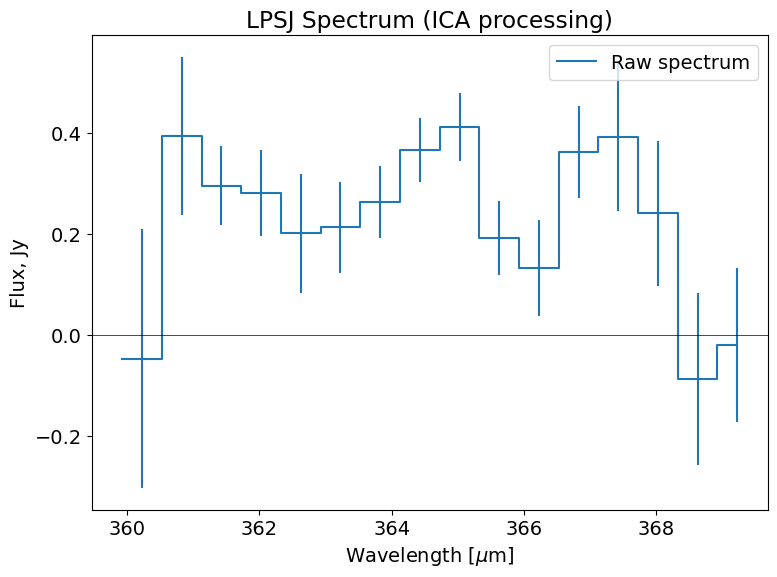

In [17]:
plot_spec((new_grid_centers,regridded_flux,regridded_err[:,0]),label="Raw spectrum")
z=3.119
line = zt.grating_cal.oiii88
obs_wav = zt.grating_cal.wavelength_z(z,line)
#plt.axvline(obs_wav)
plt.title("LPSJ Spectrum (ICA processing)")
plt.xlabel("Wavelength [$\mu$m]")
plt.axhline(y=0,color='k',linewidth=0.5)
plt.legend()
plt.tight_layout()


## Continuum Subtraction
For continuum subtraction, I have two different methods. The first is to take all of the data points in the spectrum besides the two line pixels and weighted averages them. The second is to take all the pixels besides the line pixel and do a linear fit. Then I subtract either the constant or the linear model from the spectrum. The first method also gives a continuum flux and uncertainty.

In [18]:
line_wl_range = [364,365.5]
new_data = drop_nans((new_grid_centers,regridded_flux,regridded_err[:,0]))
_,_,bins = drop_nans((new_grid_centers,regridded_flux,bins_new))
subbed_data = wl_contsub(new_data,line_wl_range)
linear_sub_data = wl_linear_contsub(new_data,line_wl_range)
z_sub_data = wl_zeroth_contsub(new_data,line_wl_range)

In [19]:
#plot_spec(subbed_data)

z=3.119
line = zt.grating_cal.oiii88
obs_wav = zt.grating_cal.wavelength_z(z,line)

In [20]:
line_px_mask = np.logical_not( np.logical_or(new_data[0]<line_wl_range[0],new_data[0]>line_wl_range[1]) )
line_px_idx = line_px_mask.nonzero()[0]
step_idx=np.repeat(line_px_idx,2)

In [21]:

x = bins[line_px_idx].flatten()
y = linear_sub_data[1][step_idx]

In [22]:
continuum,cont_err=subbed_data[3:5] # continuum flux Jy and error
f"Continuum flux: {continuum:.3f} +/- {cont_err:.3f} Jy"

'Continuum flux: 0.234 +/- 0.027 Jy'

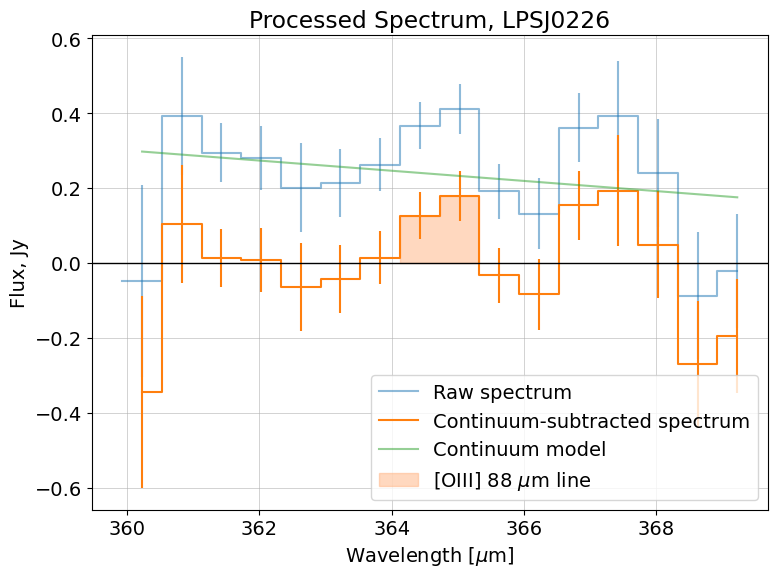

In [23]:
plot_spec((new_grid_centers,regridded_flux,regridded_err[:,0]),label="Raw spectrum",alpha=0.5)
plot_spec(linear_sub_data,label="Continuum-subtracted spectrum")
plt.plot(new_data[0], new_data[0]*linear_sub_data[3][0]+linear_sub_data[3][1],alpha=0.5, label="Continuum model")
plt.axhline(y=0,color='k',linewidth=1)

plt.title("Processed Spectrum, LPSJ0226")
plt.xlabel("Wavelength [$\mu$m]")
x = bins[line_px_idx].flatten()
y = linear_sub_data[1][step_idx]
plt.fill_between(x,y,color=(1,0.7,0.5,0.5),label="[OIII] 88 $\mu$m line")
plt.grid(which='major',linewidth=0.4)
plt.legend()
plt.tight_layout()

## Line flux estimation
To estimate the flux in the line, I add together the two bins that contain the line and add their errors in quadrature. Then if the line is less than 3$\sigma$ we can report a line limit, and if it's larger we can report a flux.

In [24]:
line_flux, line_err, line_jykms, err_jykms = line_estimator(linear_sub_data,[364,365.5],bins)

In [25]:
f"3-sigma limit: {line_err*3:.2e} W m^-2"

'3-sigma limit: 3.71e-18 W m^-2'

In [26]:
f"Computed line flux: {line_flux:.2e} +/- {line_err:.2e} W m^-2"

'Computed line flux: 4.12e-18 +/- 1.24e-18 W m^-2'

In [27]:
f"Computed line flux {line_jykms:.0f} +/- {err_jykms:.0f}"

'Computed line flux 150 Jy km / s +/- 45 Jy km / s'

### Line flux comparison to predictions

Gordon predicted continuum flux [Jy] = 1.8; we got $0.23\pm0.03$ Jy. The idea is that Planck flux could be too high since it was confusion-limited, also the source is an einstein ring so we'll only cover a fraction of it with our beam.

Gordon predicted line flux: $(9.46\pm0.473)\cdot 10^{-18}$ W m$^{-2}$ (SNR=20); we got $(4.12\pm1.24) \cdot 10^{-18}$ W m$^{-2}$, which means our noise is 2.6 times worse than Gordon's predictions.

LPS was observed for a total operating time of $15000$ s $= 4.2$ hr in PWV conditions 0.3 to 0.59 mm.

In [28]:
def displaymd(text):
    display(md(text))

In [32]:
# get LPS files
l=sorted(glob("bo_nb/LPSJ0226_ica/*"))
l=[f for f in l if "smooth" not in f]
#l
err = [f for f in l if "ica_spec_err_corr" in f and "220930_0043-0062" not in f and "220930_0000-0019" not in f]
flux = [f for f in l if "ica_spec_corr" in f and "220930_0043-0062" not in f and "220930_0000-0019" not in f]
wl = [f for f in l if "ica_wl" in f and "220930_0043-0062" not in f and "220930_0000-0019" not in f]

# load lps wavelength data
wlarr=bpio.load_data_and_extract(wl[0],0)[1]
spatial_pos = [1,0,0,0,0,0,0,0,0,0,0,0,0,0]
grating_idxs= [1770,1740,
               #1789,
               1750,
               1710,1698,
               1710,1731,
               1732,1753,
               1753,1770,1740,1753]   
def data_handler(flux_files,err_files,spatial_pos,grating_idx, line_wl_range, name):
    displaymd(f"# Process {name}")
    # Load data
    displaymd("## Raw Data")
    flux_data = [bpio.load_data_and_extract(f,s,err_file=e) for f,s,e in zip(flux,spatial_pos,err)]
    # calculate original grids
    orig_wl_edges=[]
    for spat,idx in zip(spatial_pos,grating_idx):
        orig_wl_edges.append((gc.phys_px_to_wavelength(np.arange(20)-0.5,spat,350,idx),gc.phys_px_to_wavelength(np.arange(20)+0.5,spat,350,idx)))
    grid_arr = np.array(orig_wl_edges)
    
    # create new grid
    new_grid = np.arange(np.min(grid_arr),np.max(grid_arr),0.6)
    bins_new = np.stack((new_grid[:-1], new_grid[1:]), axis=1)
    
    # AVERAGE ALL DATA TO NEW GRID
    regridded_flux,regridded_err = regridding_weighted_average(bins_new,orig_wl_edges,flux_data)
    new_grid_centers = np.average(bins_new,axis=1)
    
    # Raw data plot
    plt.figure()
    plot_spec((new_grid_centers,regridded_flux,regridded_err[:,0]),label="Raw spectrum")
    z=3.119
    line = zt.grating_cal.oiii88
    obs_wav = zt.grating_cal.wavelength_z(z,line)
    #plt.axvline(obs_wav)
    plt.title(f"{name} Spectrum (ICA processing)")
    plt.xlabel("Wavelength [$\mu$m]")
    plt.axhline(y=0,color='k',linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    displaymd("## Continuum Subtraction")
    new_data = drop_nans((new_grid_centers,regridded_flux,regridded_err[:,0]))
    _,_,bins = drop_nans((new_grid_centers,regridded_flux,bins_new))
    subbed_data = wl_contsub(new_data,line_wl_range)
    linear_sub_data = wl_linear_contsub(new_data,line_wl_range)
    z_sub_data = wl_zeroth_contsub(new_data,line_wl_range)
    
    # compute line location
    line_px_mask = np.logical_not( np.logical_or(new_data[0]<line_wl_range[0],new_data[0]>line_wl_range[1]) )
    line_px_idx = line_px_mask.nonzero()[0]
    step_idx=np.repeat(line_px_idx,2)
    
    # print continuum flux
    continuum,cont_err=subbed_data[3:5] # continuum flux Jy and error
    displaymd(f"Continuum flux: ${continuum:.3f} \pm {cont_err:.3f}$ Jy")
    
    # Advanced figure
    plt.figure()
    plot_spec((new_grid_centers,regridded_flux,regridded_err[:,0]),label="Raw spectrum",alpha=0.5)
    plot_spec(linear_sub_data,label="Continuum-subtracted spectrum")
    plt.plot(new_data[0], new_data[0]*linear_sub_data[3][0]+linear_sub_data[3][1],alpha=0.5, label="Continuum model")
    plt.axhline(y=0,color='k',linewidth=1)

    plt.title(f"Processed Spectrum, {name}")
    plt.xlabel("Wavelength [$\mu$m]")
    x = bins[line_px_idx].flatten()
    y = linear_sub_data[1][step_idx]
    plt.fill_between(x,y,color=(1,0.7,0.5,0.5),label="[OIII] 88 $\mu$m line")
    plt.grid(which='major',linewidth=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    displaymd("## Line flux estimation")
    line_flux, line_err, line_jykms, err_jykms = line_estimator(linear_sub_data,line_wl_range,bins)
    displaymd(f"3-sigma limit: ${num2tex(line_err*3,precision=3)}$ W m$^{{-2}}$")
    displaymd(f"Computed line flux: ${num2tex(line_flux,precision=3)} \pm {num2tex(line_err,precision=3)}$ W m$^{{-2}}$")
    displaymd(f"Computed line flux {line_jykms:.0f} $\pm$ {err_jykms:.0f}")

In [33]:
#data_handler(flux,err,spatial_pos,grating_idxs,[364,365.5],"LPSJ0226")

# HLSJ0455

# Process HLSJ0455

## Raw Data

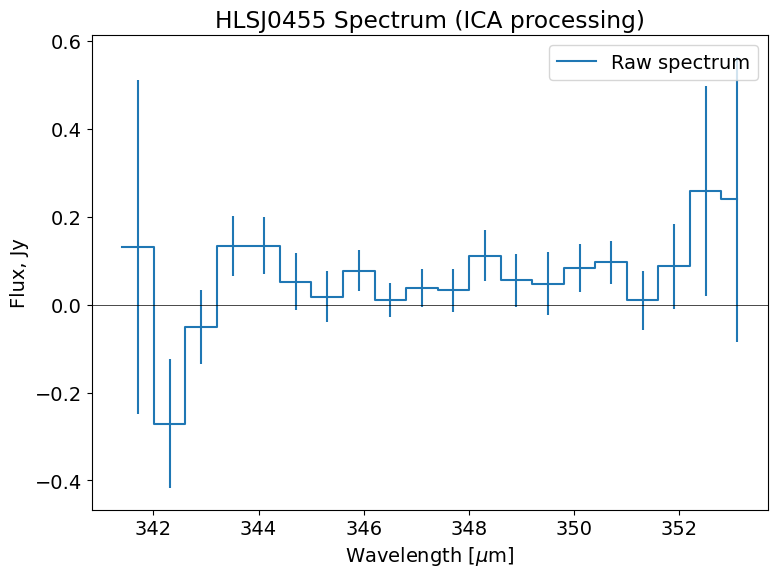

## Continuum Subtraction

Continuum flux: $0.053 \pm 0.015$ Jy

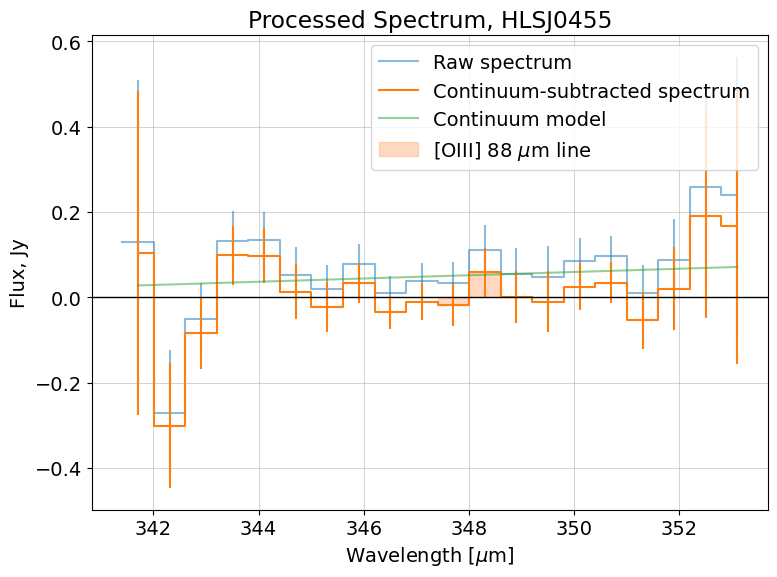

## Line flux estimation

3-sigma limit: $3.37 \cdot 10^{-18}$ W m$^{-2}$

Computed line flux: $6.02 \cdot 10^{-19} \pm 1.12 \cdot 10^{-18}$ W m$^{-2}$

Computed line flux 21 Jy km / s $\pm$ 39 Jy km / s

In [34]:
# get files
l=sorted(glob("bo_nb/HLSJ0455/*"))
l=[f for f in l if "smooth" not in f]
#l
err = [f for f in l if "ica_spec_err_corr" in f and "220930_0043-0062" not in f and "220930_0000-0019" not in f]
flux = [f for f in l if "ica_spec_corr" in f and "220930_0043-0062" not in f and "220930_0000-0019" not in f]
wl = [f for f in l if "ica_wl" in f and "220930_0043-0062" not in f and "220930_0000-0019" not in f]

# load lps wavelength data
wlarr=bpio.load_data_and_extract(wl[0],0)[1]

grat_idx=[2456,2436,2416,2476,2396,2416,2416,2375,2436,2436,2476,2436,2436,2416,2416]

spatial_pos = itertools.repeat(0)

data_handler(flux,err,spatial_pos,grat_idx,[347.5,348.5],"HLSJ0455")

### Compare to predictions

Gordon predicts line flux $(6.34\pm0.37)\cdot10^{-18} \textrm{ W m}^{-2}$ or a $3\sigma$ line limit of $1.12\cdot10^{-18} \textrm{ W m}^{-2}$, whereas we get a line limit of $3.37\cdot10^{-18} \textrm{ W m}^{-2}$, a factor of $3$ worse than predicted.

HLS was observed for a total operating time of $13200$ s $=3.6$ hr in PWV conditions 0.42-0.58 mm.

# SPT J0550

In [55]:
# get files
l=sorted(glob("bo_nb/SPTJ0550/*"))
l=[f for f in l if "smooth" not in f]
#l
err = [f for f in l if "ica_spec_err_corr" in f ]
flux = [f for f in l if "ica_spec_corr" in f ]
wl = [f for f in l if "ica_wl" in f]
info = [f for f in l if "ica_beam_pairs_info" in f]
# load lps wavelength data
wlarr=bpio.load_data_and_extract(wl[0],0)[1]

grat_idx=[pandas.read_csv(f)['gratingindex'][0] for f in info]

spatial_pos = itertools.repeat(0)



In [57]:
grat_idx

[1710, 1710, 1690, 1690, 1670, 1670, 1730, 1730]

# Process SPTJ0550

## Raw Data

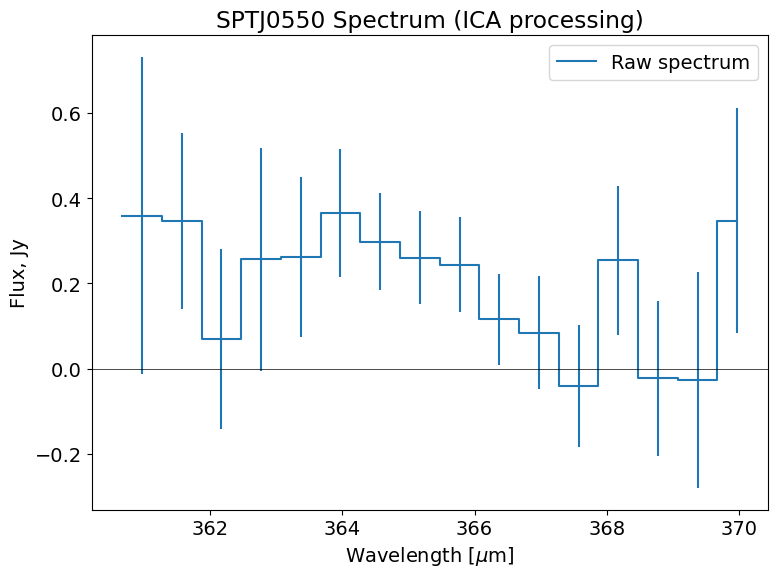

## Continuum Subtraction

Continuum flux: $0.127 \pm 0.051$ Jy

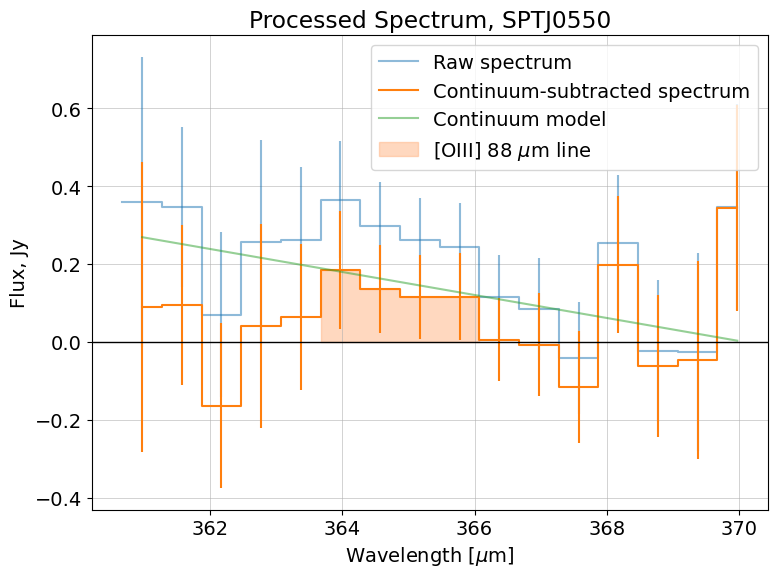

## Line flux estimation

3-sigma limit: $9.91 \cdot 10^{-18}$ W m$^{-2}$

Computed line flux: $7.47 \cdot 10^{-18} \pm 3.3 \cdot 10^{-18}$ W m$^{-2}$

Computed line flux 272 Jy km / s $\pm$ 120 Jy km / s

In [60]:
data_handler(flux,err,spatial_pos,grat_idx,[363.9,366],"SPTJ0550")

In [61]:
z=3.119
line = zt.grating_cal.oiii88
obs_wav = zt.grating_cal.wavelength_z(z,line)
obs_wav

363.938364

This source has 4500 s = 75 min = 1.25 hr of observing time. 78 mjy continuum predicted. Gordon says "P2: [CII] line~0.25 Jy, 700 km/s FWZP" which is 175 Jy km s$^{-1}$ at SNR 6, so here we're doing about 4x worse than predicted. Though it is true that we have 4 bins in use for line flux calculation this time, which will degrade our performance compared to the esimates, which I believe assume 1 pixel.

# W0533

$z=2.904$


In [92]:
# get files
l=sorted(glob("bo_nb/W0533/*"))
l=[f for f in l if "smooth" not in f]
#l
err = [f for f in l if "ica_spec_err_corr" in f ]
flux = [f for f in l if "ica_spec_corr" in f ]
wl = [f for f in l if "ica_wl" in f]
info = [f for f in l if "ica_beam_pairs_info" in f]
# load lps wavelength data
wlarr=bpio.load_data_and_extract(wl[0],0)[1]

grat_idx=[pandas.read_csv(f)['gratingindex'][0] for f in info]

spatial_pos = itertools.repeat(0)



In [95]:
z=2.904
line = zt.grating_cal.oiii88
obs_wav = zt.grating_cal.wavelength_z(z,line)
obs_wav

344.941824

# Process W0533

## Raw Data

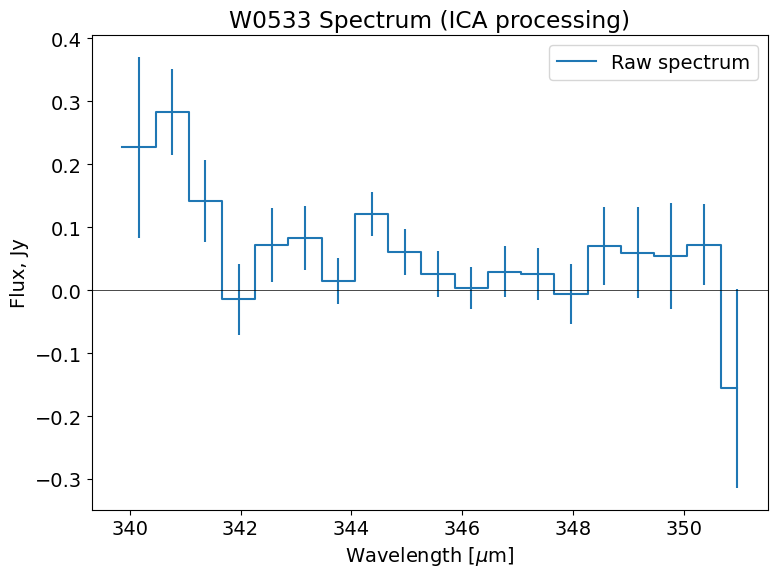

## Continuum Subtraction

Continuum flux: $0.042 \pm 0.013$ Jy

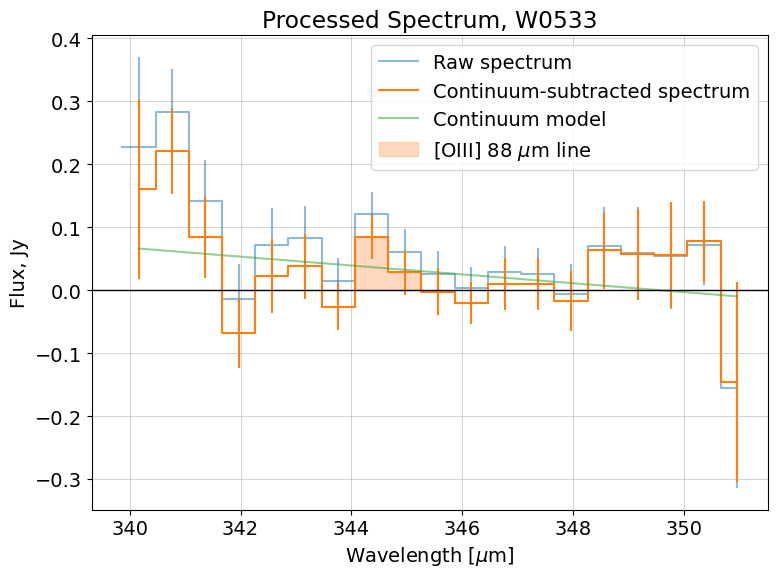

## Line flux estimation

3-sigma limit: $2.3 \cdot 10^{-18}$ W m$^{-2}$

Computed line flux: $1.71 \cdot 10^{-18} \pm 7.66 \cdot 10^{-19}$ W m$^{-2}$

Computed line flux 59 Jy km / s $\pm$ 26 Jy km / s

In [99]:
data_handler(flux,err,spatial_pos,grat_idx,[344,345],"W0533")

Gordon predicts 85 mjy continuum, $4.28\cdot10^{-18}$ W m$^{-2}$ of [OIII] flux. We have 190m = 11430s = 3.175 hr of integration time here, SNR=12 is predicted. So predicted error would be $\pm 0.36\cdot10^{-18}$ W m$^{-2}$ and a 3$\sigma$ upper limit would be $1.07\cdot10^{-18}$ W m$^{-2}$ So here we're doing about 2x worse than predicted, not bad.

# PLCKG200

In [100]:
# get files
l=sorted(glob("bo_nb/G200/*"))
l=[f for f in l if "smooth" not in f]
#l
err = [f for f in l if "ica_spec_err_corr" in f ]
flux = [f for f in l if "ica_spec_corr" in f ]
wl = [f for f in l if "ica_wl" in f]
info = [f for f in l if "ica_beam_pairs_info" in f]
# load lps wavelength data
wlarr=bpio.load_data_and_extract(wl[0],0)[1]

grat_idx=[pandas.read_csv(f)['gratingindex'][0] for f in info]

spatial_pos = itertools.repeat(0)



In [103]:
z=2.973
line = zt.grating_cal.oiii88
obs_wav = zt.grating_cal.wavelength_z(z,line)
obs_wav

351.03838799999994

# Process Planck G200

## Raw Data

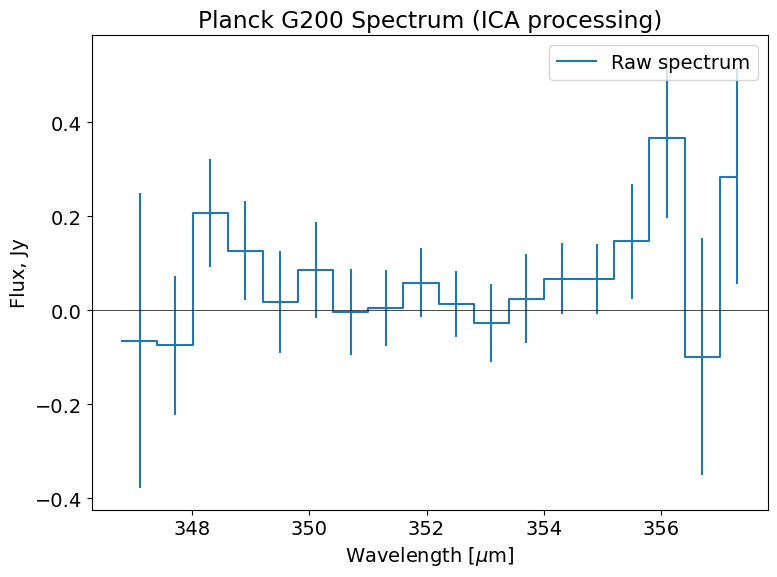

## Continuum Subtraction

Continuum flux: $0.057 \pm 0.026$ Jy

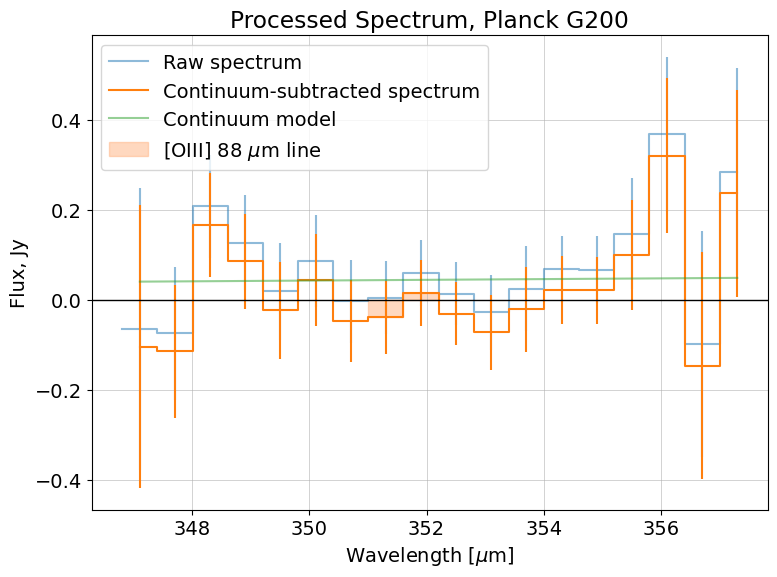

## Line flux estimation

3-sigma limit: $4.76 \cdot 10^{-18}$ W m$^{-2}$

Computed line flux: $-3.54 \cdot 10^{-19} \pm 1.59 \cdot 10^{-18}$ W m$^{-2}$

Computed line flux -12 Jy km / s $\pm$ 56 Jy km / s

In [111]:
data_handler(flux,err,spatial_pos,grat_idx,[351,352],"Planck G200")

Gordon predicts 31 mjy continuum, $5.5\cdot10^{-18}$ W m$^{-2}$ of [OIII] flux. We have 165m = 9930s = 2.75 hr of integration time here, SNR=9 is predicted. So predicted error would be $\pm 0.61\cdot10^{-18}$ W m$^{-2}$ and a 3$\sigma$ upper limit would be $1.83\cdot10^{-18}$ W m$^{-2}$ So here we're doing about 2.6x worse than predicted.

Here, the 3 sigma limit is pretty close to the computed line flux, which is especially disappointing.

In [110]:
4.8/(5.5/9*3)

2.6181818181818177